# Using ML

In [1]:
import gc
import os
import pickle
import random
import shutil
import warnings

import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings("ignore")
face_cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(face_cascade_path)

In [2]:
train_dir = "../Images/train/"
image_dir = "../Images/"
test_dir = "../Images/test/"
artifacts_dir = "../Artifacts"

In [3]:
# Clean
for file_ in os.listdir("../Artifacts/"):
    if ".pkl" in file_:
        os.remove(f"../Artifacts/{file_}")

if "train" in os.listdir(image_dir):
    shutil.rmtree(train_dir)
    if "test" in os.listdir(image_dir):
        shutil.rmtree(test_dir)
shutil.copytree("../train/", "../Images/train")

'../Images/train'

#  Preprocessing

## Histogram Eqalization

In [4]:
def heq(path_):
    img = cv2.imread(path_, cv2.IMREAD_COLOR)
    if img.shape[0] < 100:
        os.remove(path_)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # _Convert_to_HSV_colorspace

    # Creating_Mask
    hsv[:, :, 2] = cv2.equalizeHist(hsv[:, :, 2])
    Meq_color = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    cv2.imwrite(path_, Meq_color)


for _ in range(2):
    for class_ in os.listdir(train_dir):
        for img_ in os.listdir(f"{train_dir}/{class_}"):
            heq(path_=f"{train_dir}/{class_}/{img_}")

## Sample Data

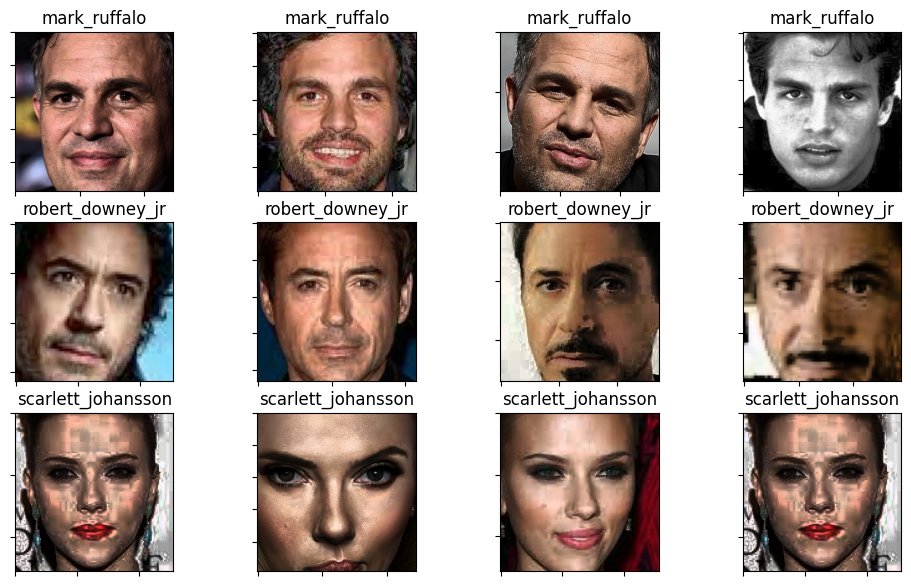

In [5]:
def get_randoms():
    gc.collect()
    img_dirs = os.listdir(train_dir)
    classes_ = sorted(os.listdir(train_dir))
    fig, ax = plt.subplots(len(classes_), 4, figsize=(12, 7))

    j = 0
    for img_dir in img_dirs:
        i = 0
        choices = random.choices(os.listdir(f"{train_dir}/{img_dir}"), k=4)
        for img_ in choices:
            path_ = f"{train_dir}/{img_dir}/{img_}"
            img = cv2.imread(path_)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax[j][i].set_title(f"{img_dir}")
            ax[j][i].imshow(img)
            ax[j][i].set_xticklabels([])
            ax[j][i].set_yticklabels([])
            i += 1
        j += 1


get_randoms()

## ROI - returns face which is region of intrest 

In [6]:
face_cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(face_cascade_path)


for class_ in os.listdir(train_dir):
    for img_ in os.listdir(f"{train_dir}/{class_}"):
        img_array = cv2.imread(f"{train_dir}/{class_}/{img_}")
        # img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(
            img_array, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30)
        )
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            img_array = img_array[y : y + h, x : x + w]
            cv2.imwrite(f"{train_dir}/{class_}/{img_}", img_array)
            if (
                os.path.getsize(f"{train_dir}/{class_}/{img_}") < 12000
                or img_array.shape[0] < 100
            ):
                print(f"{train_dir}/{class_}/{img_}")
                os.remove(f"{train_dir}/{class_}/{img_}")

../Images/train//mark_ruffalo/mark_ruffalo1.png
../Images/train//mark_ruffalo/mark_ruffalo11.png
../Images/train//mark_ruffalo/mark_ruffalo12.png
../Images/train//mark_ruffalo/mark_ruffalo13.png
../Images/train//mark_ruffalo/mark_ruffalo15.png
../Images/train//mark_ruffalo/mark_ruffalo2.png
../Images/train//mark_ruffalo/mark_ruffalo22.png
../Images/train//mark_ruffalo/mark_ruffalo24.png
../Images/train//mark_ruffalo/mark_ruffalo35.png
../Images/train//mark_ruffalo/mark_ruffalo39.png
../Images/train//mark_ruffalo/mark_ruffalo4.png
../Images/train//mark_ruffalo/mark_ruffalo7.png
../Images/train//mark_ruffalo/mark_ruffalo8.png
../Images/train//robert_downey_jr/robert_downey_jr14.png
../Images/train//robert_downey_jr/robert_downey_jr2.png
../Images/train//robert_downey_jr/robert_downey_jr24.png
../Images/train//robert_downey_jr/robert_downey_jr26.png
../Images/train//robert_downey_jr/robert_downey_jr27.png
../Images/train//robert_downey_jr/robert_downey_jr28.png
../Images/train//robert_dow

## Class Balance, Split

In [7]:
class preprocessing:
    def __init__(self, class_names=None):
        self.img_dir = train_dir
        self.classes = os.listdir(self.img_dir)
        # Returns a list of all class names in the training image.
        if not class_names:
            class_names = os.listdir(self.img_dir)
        self.class_names = class_names
        self.test_dir = test_dir

    # Class balance
    def class_balance(self):
        class_size = []
        # Add the size of each class in the class_names list.
        for class_name in self.class_names:
            w_dir_ = self.img_dir + class_name + "/"
            class_size.append(len(os.listdir(w_dir_)))
        max_index = class_size.index(max(class_size))
        # Copy all classes in the training directory to the train directory.
        for class_name in self.class_names:
            w_dir_ = self.img_dir + class_name + "/"
            size_ = len(os.listdir(w_dir_))
            differ = class_size[max_index] - size_
            # Copy random choices from the current class size to the current class size.
            if size_ != class_size[max_index]:
                choices = random.choices(os.listdir(w_dir_), k=differ)
                # Copy all the choices in the choices list to the current directory.
                for choice in choices:
                    try:
                        shutil.copy(
                            w_dir_ + choice,
                            w_dir_ + choice.replace("Image", "Image_copy"),
                        )
                    except:
                        break
            size_ = len(os.listdir(w_dir_))
            if size_ != class_size[max_index]:
                self.class_balance()
        self.split_images()

    def split_images(self):
        # Splitting Images into train,test
        try:
            os.mkdir(self.test_dir)
        except:
            pass
        # Move images from the test directory to the test directory.
        for class_ in self.class_names:
            _images = os.listdir(self.img_dir + class_)
            total_images = len(_images)
            choice = random.choices(_images, k=int(total_images * 0.2))  # 40% test
            if class_ not in os.listdir(self.test_dir):
                os.mkdir(self.test_dir + "/" + class_)
            # Move all files in choice to the test directory
            for i in choice:
                try:
                    shutil.move(
                        self.img_dir + class_ + "/" + i,
                        self.test_dir + "/" + class_,
                    )
                except:
                    continue
        # self.augment_()

    def augment_image(self, image, output_dir, prefix):
        resized = image

        # Rotate
        angle = np.random.randint(-15, 15)
        rows, cols, _ = resized.shape
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        rotated = cv2.warpAffine(resized, M, (cols, rows))

        # Flip
        flip_direction = np.random.randint(
            0, 3
        )  # 0 = horizontal flip, 1 = vertical flip, 2 = both flips
        flipped = cv2.flip(rotated, flip_direction - 1)

        # Save augmented image
        output_path = os.path.join(output_dir, f"{prefix}_augmented.jpg")
        cv2.imwrite(output_path, flipped)
        # print(f"Augmented image saved: {output_path}")

    def augment_images_in_directory(self, input_dir, output_dir):
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

        # Loop through images in input directory
        for filename in os.listdir(input_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_path = os.path.join(input_dir, filename)

                # Load image
                image = cv2.imread(image_path)

                # Augment image
                self.augment_image(image, output_dir, os.path.splitext(filename)[0])

    def augment_(self):
        # Specify input and output directories
        w_dir = self.img_dir

        for class_ in os.listdir(w_dir):
            input_directory = f"{w_dir}/{class_}"
            output_directory = f"{w_dir}/{class_}"
            self.augment_images_in_directory(input_directory, output_directory)


obj = preprocessing()
# obj.class_balance()
obj.split_images()

# Train Test Split

In [8]:
def tranform_image(DATA_DIR):
    target = []
    images = []
    flatten_data = []

    CATEGORIES = os.listdir(DATA_DIR)

    for categories in CATEGORIES:
        class_num = CATEGORIES.index(categories)  # label encoding
        path = os.path.join(DATA_DIR, categories)
        for img in os.listdir(path):
            img_array = imread(os.path.join(path, img))
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            img_resized = resize(img_array, (160, 160, 3))
            flatten_data.append(img_resized.flatten())  # Normalizes values
            images.append(img_resized)
            target.append(class_num)

    flatten_data = np.array(flatten_data)
    target = np.array(target)
    images = np.array(images)

    return flatten_data, target

In [9]:
x_train, y_train = tranform_image(train_dir)

x_test, y_test = tranform_image(test_dir)


def train_model_(model, grid_params=None):
    if grid_params != None:
        clf = GridSearchCV(model, grid_params, cv=5, scoring="accuracy")
    else:
        clf = model
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    res = accuracy_score(y_test, y_pred)
    print("\nAccuracy_score", res)
    print(
        "\nClassification_report\n",
        classification_report(y_test, y_pred, zero_division=0),
    )
    return clf, res


for root, dirs, files in os.walk(train_dir):
    print(f"{root} : {len(files)}")

for root, dirs, files in os.walk(test_dir):
    print(f"{root} : {len(files)}")

../Images/train/ : 0
../Images/train/mark_ruffalo : 44
../Images/train/robert_downey_jr : 28
../Images/train/scarlett_johansson : 34
../Images/test/ : 0
../Images/test/mark_ruffalo : 9
../Images/test/robert_downey_jr : 6
../Images/test/scarlett_johansson : 8


# Train step

In [10]:
model = svm.SVC(C=100, class_weight=None, gamma="auto", kernel="rbf", probability=True)

grid_params = {
    "C": [1.0, 10.0, 100.0],
    "kernel": ["linear", "rbf", "poly", "sigmoid"],
    "gamma": ["scale", "auto"],
    "class_weight": [None, "balanced"],
}

models = []
model_1, acc = train_model_(model, grid_params=None)
if acc > 0.85:
    models.append(model_1)
gc.collect()


Accuracy_score 0.9565217391304348

Classification_report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.83      0.91         6
           2       0.89      1.00      0.94         8

    accuracy                           0.96        23
   macro avg       0.96      0.94      0.95        23
weighted avg       0.96      0.96      0.96        23



28517

In [11]:
model = RandomForestClassifier(
    criterion="gini",
    max_features="log2",
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=200,
)

model = RandomForestClassifier(
    criterion="entropy",
    max_depth=10,
    max_features="log2",
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
)

grid_params = {
    "n_estimators": [100, 200, 300],  # Number of trees in the forest
    "criterion": ["gini", "entropy"],  # Function to measure the quality of a split
    "max_depth": [None, 5, 10],  # Maximum depth of the tree
    "min_samples_split": [
        2,
        5,
        10,
    ],  # Minimum number of samples required to split a node
    "min_samples_leaf": [
        1,
        2,
        4,
    ],  # Minimum number of samples required at each leaf node
    "max_features": [
        "sqrt",
        "log2",
    ],  # Number of features to consider when looking for the best split
}

model_2, acc = train_model_(model, grid_params=None)
if acc > 0.85:
    models.append(model_2)
gc.collect()


Accuracy_score 0.782608695652174

Classification_report
               precision    recall  f1-score   support

           0       0.67      0.89      0.76         9
           1       1.00      0.67      0.80         6
           2       0.86      0.75      0.80         8

    accuracy                           0.78        23
   macro avg       0.84      0.77      0.79        23
weighted avg       0.82      0.78      0.79        23



40

In [12]:
model = KNeighborsClassifier(
    algorithm="auto", leaf_size=30, n_neighbors=3, p=1, weights="uniform"
)

grid_params = {
    "n_neighbors": [3, 5, 7],  # Number of neighbors to consider
    "weights": ["uniform", "distance"],  # Weight function used in prediction
    "algorithm": [
        "auto",
        "ball_tree",
    ],  # Algorithm used to compute the nearest neighbors
    "leaf_size": [30, 50, 80],  # Leaf size for the ball tree or KD tree
    "p": [1, 2],  # Power parameter for the Minkowski distance metric
}

model_3, acc = train_model_(model, grid_params=None)
if acc > 0.85:
    models.append(model_3)
gc.collect()


Accuracy_score 0.8260869565217391

Classification_report
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         9
           1       1.00      0.50      0.67         6
           2       0.88      0.88      0.88         8

    accuracy                           0.83        23
   macro avg       0.88      0.79      0.80        23
weighted avg       0.86      0.83      0.81        23



0

In [13]:
model = LogisticRegression(
    C=10.0,
    class_weight=None,
    fit_intercept=False,
    max_iter=200,
    penalty="l2",
    solver="saga",
)

grid_params = {
    "penalty": ["l1", "l2"],  # Regularization penalty ('l1' or 'l2')
    "C": [0.1, 1.0, 10.0],  # Inverse of regularization strength
    "solver": ["liblinear", "saga"],  # Algorithm to use for optimization
    "max_iter": [200],  # Maximum number of iterations
    "fit_intercept": [True, False],  # Whether to include an intercept term
    "class_weight": [None, "balanced"],  # Weights associated with classes
}

model_4, acc = train_model_(model, grid_params=None)
if acc > 0.85:
    models.append(model_4)
gc.collect()


Accuracy_score 0.9565217391304348

Classification_report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.83      0.91         6
           2       0.89      1.00      0.94         8

    accuracy                           0.96        23
   macro avg       0.96      0.94      0.95        23
weighted avg       0.96      0.96      0.96        23



20

# Model Presistance

In [14]:
for model_ in models:
    print(str(model_)[:3])
    pickle.dump(model_, open(f"{artifacts_dir}/{str(model_)[:3]}.pkl", "wb"))

SVC
Log


## Model Inferencing

Log.pkl
SVC.pkl


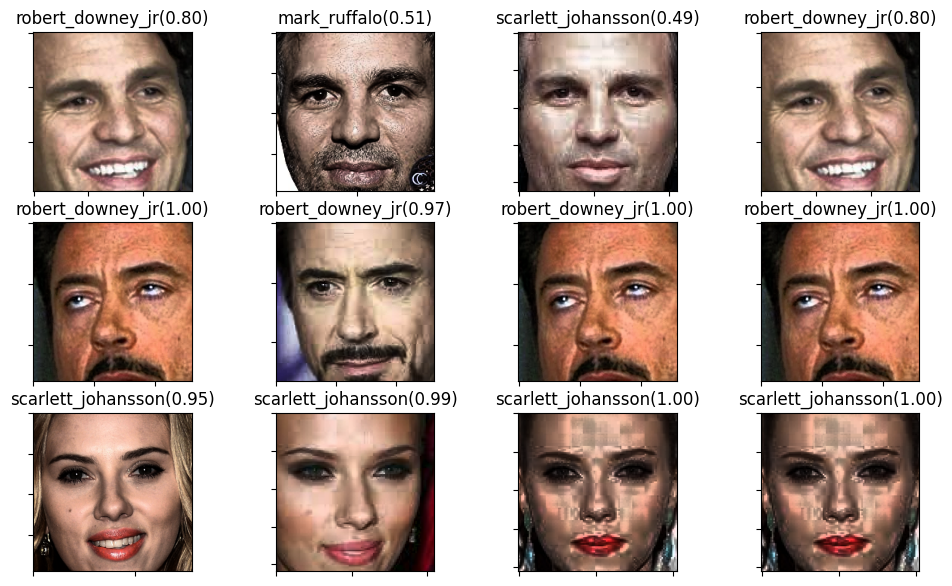

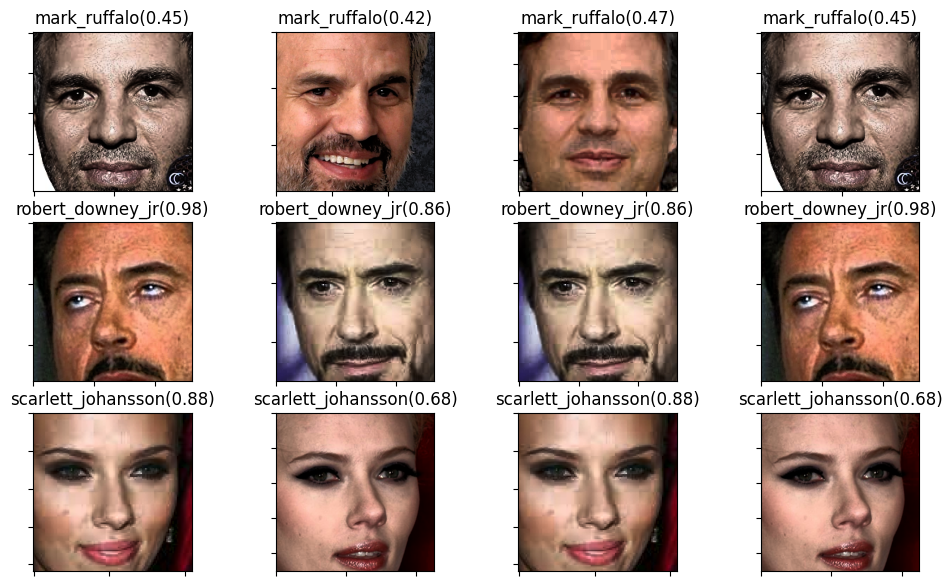

In [15]:
def predict_(img, model):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
        gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30)
    )
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        img = img[y : y + h, x : x + w]
    img_resized = resize(img, (160, 160, 3))
    flatten_data = img_resized.flatten()
    flatten_data = np.array(flatten_data, ndmin=2)
    return model.predict_proba(flatten_data), model.predict(flatten_data)[0]


def pred_randoms(model):
    gc.collect()
    img_dirs = os.listdir(test_dir)
    classes_ = sorted(os.listdir(train_dir))
    fig, ax = plt.subplots(len(classes_), 4, figsize=(12, 7))

    j = 0
    for img_dir in img_dirs:
        i = 0
        choices = random.choices(os.listdir(f"{test_dir}/{img_dir}"), k=4)
        for img_ in choices:
            path_ = f"{test_dir}/{img_dir}/{img_}"
            img = cv2.imread(path_)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            _, res = predict_(img, model)
            ax[j][i].set_title(f"{classes_[res]}({max(_[0]):.2f})")
            ax[j][i].imshow(img)
            ax[j][i].set_xticklabels([])
            ax[j][i].set_yticklabels([])
            i += 1
        j += 1


for model in os.listdir(artifacts_dir):
    if ".pkl" in model:
        print(model)
        model_ = pickle.load(open(f"{artifacts_dir}/{model}", "rb"))
        pred_randoms(model_)